In [152]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from myhelpers import printme
import preliz as pz #

print(f"Running on PyMC3 v{pm.__version__}")

ModuleNotFoundError: No module named 'preliz'

In [153]:
az.style.use("arviz-grayscale")
from cycler import cycler
default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=100)
np.random.seed(123)

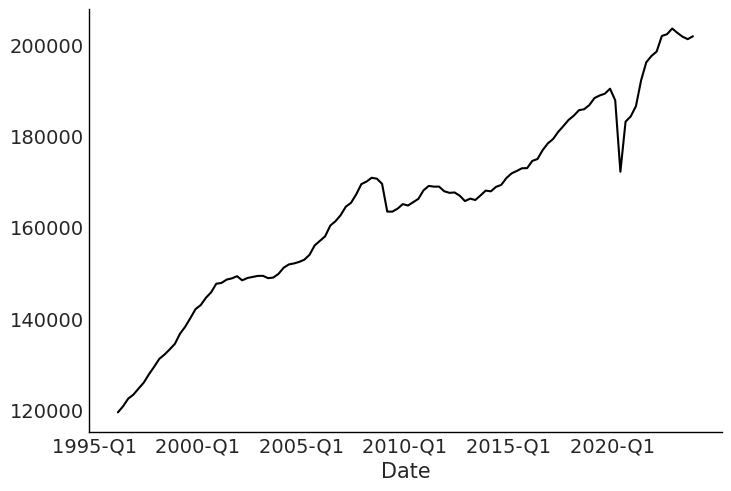

In [154]:
dt1 = pd.read_csv(r"../data/gdp_eurostatMar7th.csv", index_col=[0])
dt1['NL'].plot()
plt.show()


In [155]:
dt1 = dt1['NL']
dt1.dropna(inplace=True)

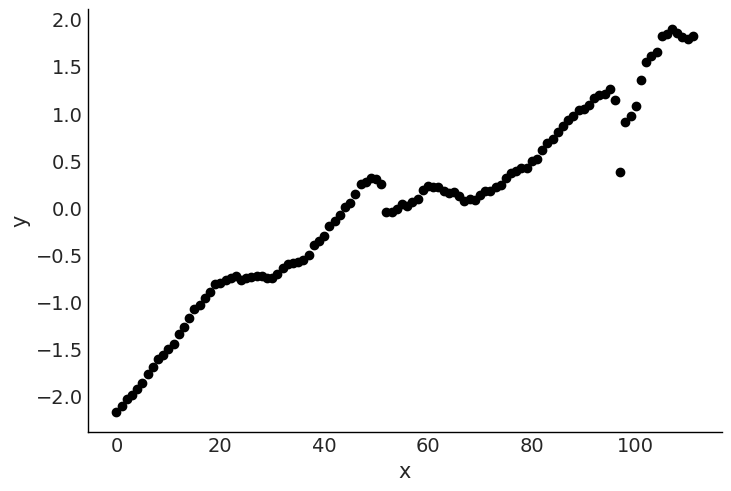

In [156]:
from scipy import signal

y = dt1.values
x = np.arange(0, len(y))

order = 3
x_p = np.vstack([x**i for i in range(1, order + 1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()
#y_c = signal.detrend(y_c)
plt.scatter(x, y_c)
plt.xlabel("x")
plt.ylabel("y");


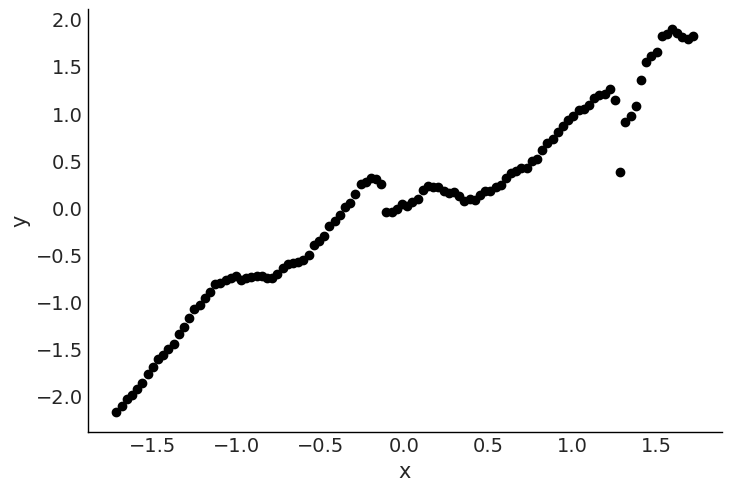

In [15]:

x_sqr = x*x
x_cube = x*x*x
y_center = (y - y.mean()) / y.std()
x_center = (x - x.mean()) / x.std()
x_sqr_center = (x_sqr - x_sqr.mean()) /x_sqr.std()
x_cube_center = (x_cube - x_cube.mean()) /x_cube.std()
constant = np.repeat(1, len(y))

plt.scatter(x_center, y_c)
plt.xlabel("x")
plt.ylabel("y");

In [16]:

N = 2000
with pm.Model() as model_l:
    # data
    x_center = pm.Data('x_center', x_center)
    y_center = pm.Data('y_center', y_center)
    
    
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 5)
  
    μ = pm.Deterministic("μ", α + β * x_center)
    
    # define likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed= y_center)

    idata_l = pm.sample(N, idata_kwargs={"log_likelihood": True})
    idata_l.extend(pm.sample_posterior_predictive(idata_l))



c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.
Sampling: [y_pred]


In [18]:
with pm.Model() as model_studentsT:

    # data
    x_center = pm.Data('x_center', x_center)
    y_center = pm.Data('y_center', y_center)
    
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 5)

    μ = pm.Deterministic("μ", α + β*x_center)

    # define likelihood
    y_pred = pm.StudentT("y_pred", mu=μ, sigma=σ, nu=2, observed = y_center)

    idata_students = pm.sample(N, idata_kwargs={"log_likelihood": True})
    idata_students.extend(pm.sample_posterior_predictive(idata_students))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
Sampling: [y_pred]


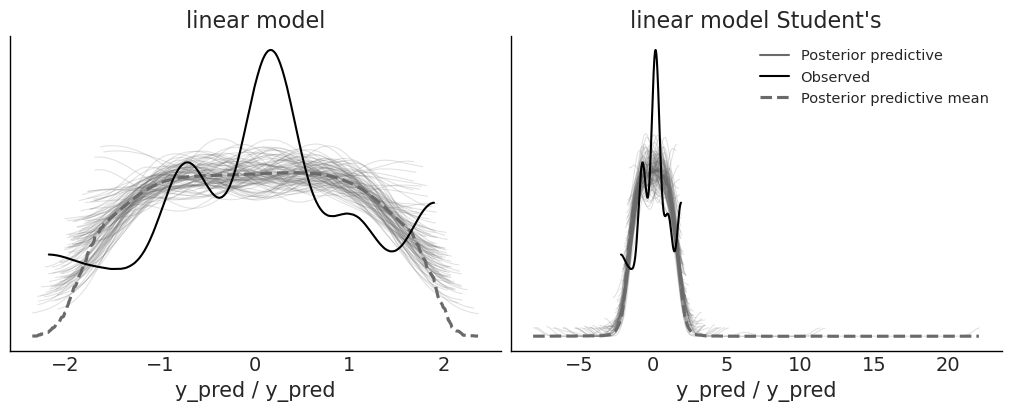

In [19]:
# Compare distribution with and with robust distribution

_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"])
axes[0].set_title("linear model")
az.plot_ppc(idata_students, num_pp_samples=100, ax=axes[1], colors=["C1", "C0", "C1"])
axes[1].set_title(f"linear model Student's")

plt.savefig("../fig/lin-pol-ppc.png")

In [20]:

with pm.Model() as model_q:

    # data
    x_center = pm.Data('x_center', x_center)
    x_sqr_center = pm.Data('x_sqr_center', x_sqr_center)
    y_center = pm.Data('y_center', y_center)
    
    α = pm.Normal("α", mu=0, sigma=1)
    β1 = pm.Normal("β1", mu=0, sigma=10, shape=1)
    β2 = pm.Normal("β2", mu=0, sigma=10, shape=1)
    σ = pm.HalfNormal("σ", 5)

    μ = pm.Deterministic("μ", α + β1*x_center + β2* x_sqr_center)

    # define likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed = y_center)

    idata_q = pm.sample(N, idata_kwargs={"log_likelihood": True})
    idata_q.extend(pm.sample_posterior_predictive(idata_q))



c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.
Sampling: [y_pred]


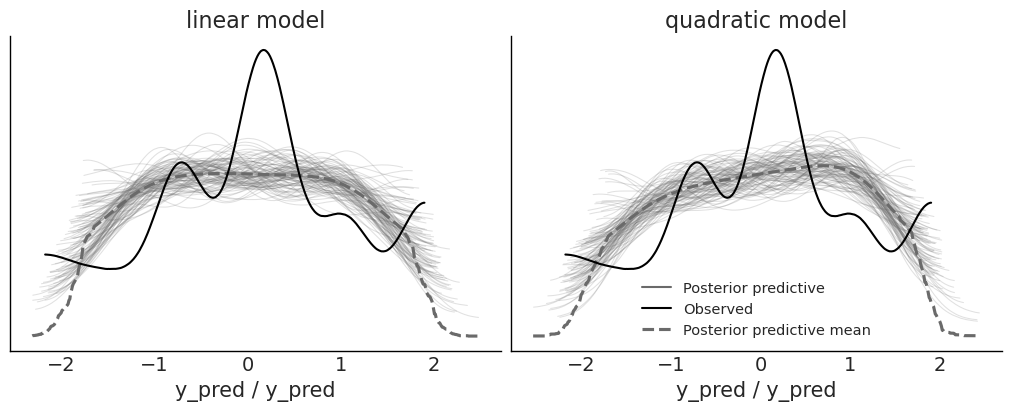

In [21]:
# compare linear with quadratic
# Compare distribution with and with robust distribution

_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"])
axes[0].set_title("linear model")
az.plot_ppc(idata_q, num_pp_samples=100, ax=axes[1], colors=["C1", "C0", "C1"])
axes[1].set_title(f"quadratic model")

plt.savefig("../fig/lin-pol-ppc_1.png")


In [56]:
# remove outliers
dt1 = pd.read_csv(r"../data/gdp_eurostatMar7th.csv", index_col=[0])
dt1 = dt1[['NL']]
dt1.dropna(inplace=True)
# replace 2020-Q2
dt1[dt1.index == "2020-Q2 "] = 187875.7
y = dt1['NL'].values

x = np.arange(0, len(y))

order = 3
x_p = np.vstack([x**i for i in range(1, order + 1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()
#y_c = signal.detrend(y_c)

x_sqr = x*x
x_cube = x*x*x
y_center = (y - y.mean()) / y.std()
x_center = (x - x.mean()) / x.std()
x_sqr_center = (x_sqr - x_sqr.mean()) /x_sqr.std()
x_cube_center = (x_cube - x_cube.mean()) /x_cube.std()
constant = np.repeat(1, len(y))

plt.scatter(x_center, y_center)
plt.xlabel("x")
plt.ylabel("y");


In [59]:

N = 2000
with pm.Model() as model_l:
    # data
    x_center = pm.Data('x_center', x_center)
    y_center = pm.Data('y_center', y_center)
    
    
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 5)
  
    μ = pm.Deterministic("μ", α + β * x_center)
    
    # define likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed= y_center)

    idata_l = pm.sample(N, idata_kwargs={"log_likelihood": True})
    idata_l.extend(pm.sample_posterior_predictive(idata_l))


c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.
Sampling: [y_pred]


In [60]:

with pm.Model() as model_q:

    # data
    x_center = pm.Data('x_center', x_center)
    x_sqr_center = pm.Data('x_sqr_center', x_sqr_center)
    y_center = pm.Data('y_center', y_center)
    
    α = pm.Normal("α", mu=0, sigma=1)
    β1 = pm.Normal("β1", mu=0, sigma=10, shape=1)
    β2 = pm.Normal("β2", mu=0, sigma=10, shape=1)
    σ = pm.HalfNormal("σ", 5)

    μ = pm.Deterministic("μ", α + β1*x_center + β2* x_sqr_center)

    # define likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed = y_center)

    idata_q = pm.sample(N, idata_kwargs={"log_likelihood": True})
    idata_q.extend(pm.sample_posterior_predictive(idata_q))

c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.
Sampling: [y_pred]


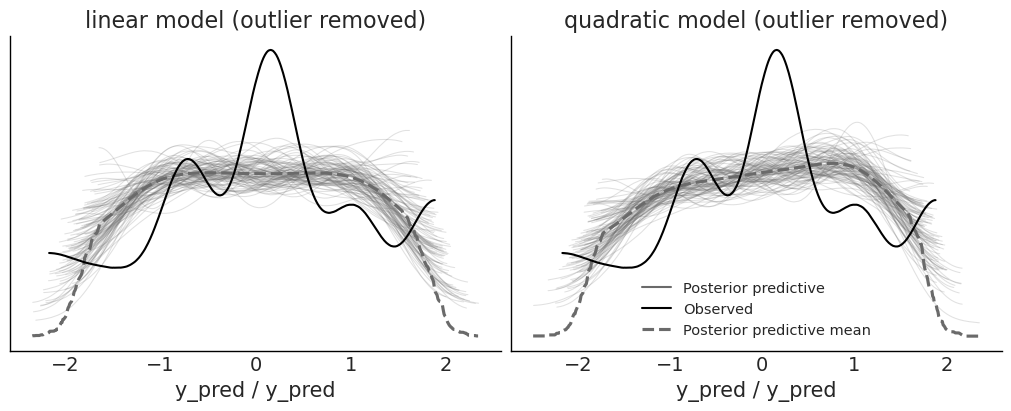

In [61]:
# compare linear with quadratic (Outlier removed)
# Compare distribution with and with robust distribution (Outlier removed)

_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"])
axes[0].set_title("linear model (outlier removed)")
az.plot_ppc(idata_q, num_pp_samples=100, ax=axes[1], colors=["C1", "C0", "C1"])
axes[1].set_title(f"quadratic model (outlier removed)")

plt.savefig("../fig/lin-pol-ppc_1_outlier.png")

In [62]:
#outlier removed

with pm.Model() as model_studentsT:

    # data
    x_center = pm.Data('x_center', x_center)
    y_center = pm.Data('y_center', y_center)
    
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 5)

    μ = pm.Deterministic("μ", α + β*x_center)

    # define likelihood
    y_pred = pm.StudentT("y_pred", mu=μ, sigma=σ, nu=2, observed = y_center)

    idata_students = pm.sample(N, idata_kwargs={"log_likelihood": True})
    idata_students.extend(pm.sample_posterior_predictive(idata_students))

c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.
Sampling: [y_pred]


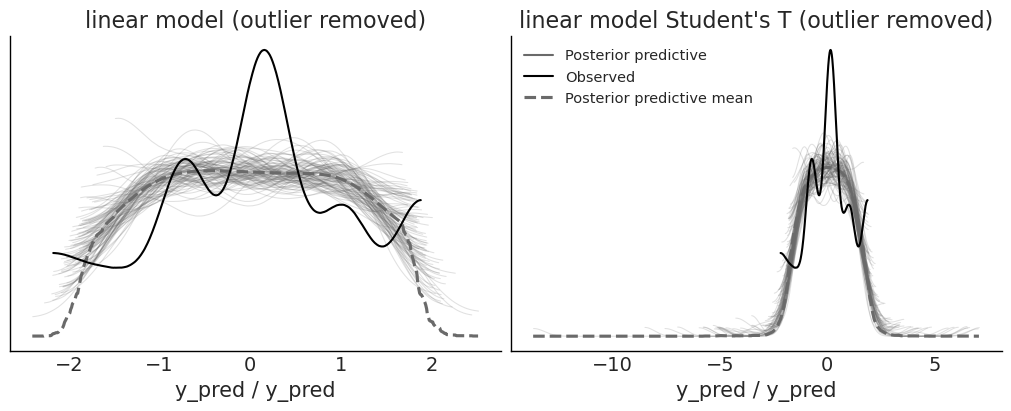

In [63]:
# compare linear with quadratic (Outlier removed)
# Compare distribution with and with robust distribution (Outlier removed)

_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"])
axes[0].set_title("linear model (outlier removed)")
az.plot_ppc(idata_students, num_pp_samples=100, ax=axes[1], colors=["C1", "C0", "C1"])
axes[1].set_title(f"linear model Student's T (outlier removed)")

plt.savefig("../fig/lin-pol-ppc_2_outlier.png")

In [105]:
# cube 

with pm.Model() as model_c:

     # data
    x_center = pm.Data('x_center', x_center)
    x_sqr_center = pm.Data('x_sqr_center', x_sqr_center)
    x_cube_center = pm.Data('x_cube_center', x_cube_center)
    y_center = pm.Data('y_center', y_center)

    α = pm.Normal("α", mu=0, sigma=1)
    β1 = pm.Normal("β1", mu=0, sigma=10, shape=1)
    β2 = pm.Normal("β2", mu=0, sigma=10, shape=1)
    β3 = pm.Normal("β3", mu=0, sigma=10, shape=1)
    σ = pm.HalfNormal("σ", 5)

    μ = pm.Deterministic("μ", α + β1*x_center + β2*x_sqr_center + β3*x_cube_center)

    # define likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed = y_center)

    idata_c = pm.sample(N, idata_kwargs={"log_likelihood": True})
    idata_c.extend(pm.sample_posterior_predictive(idata_c))

c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, β2, β3, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.
Sampling: [y_pred]


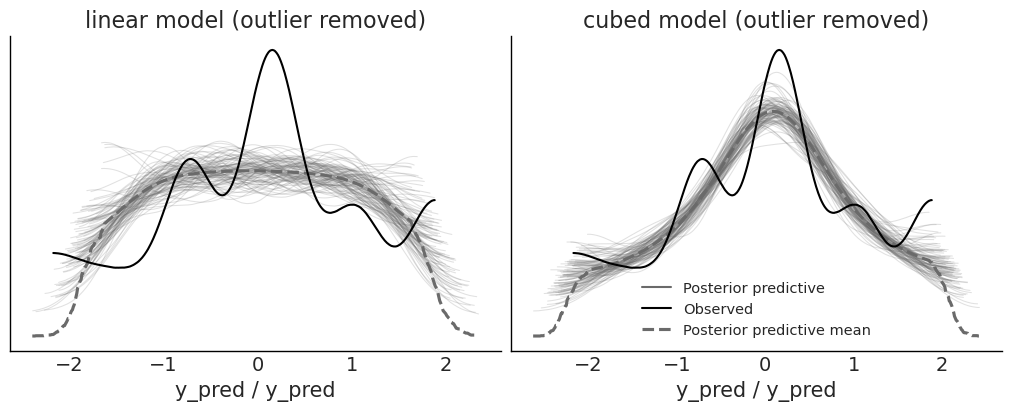

In [106]:
# compare linear with cubed (Outlier removed)
# Compare distribution with and with robust distribution (Outlier removed)

_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"])
axes[0].set_title("linear model (outlier removed)")
az.plot_ppc(idata_c, num_pp_samples=100, ax=axes[1], colors=["C1", "C0", "C1"])
axes[1].set_title(f"cubed model (outlier removed)")

plt.savefig("../fig/lin-pol-ppc_3_outlier.png")

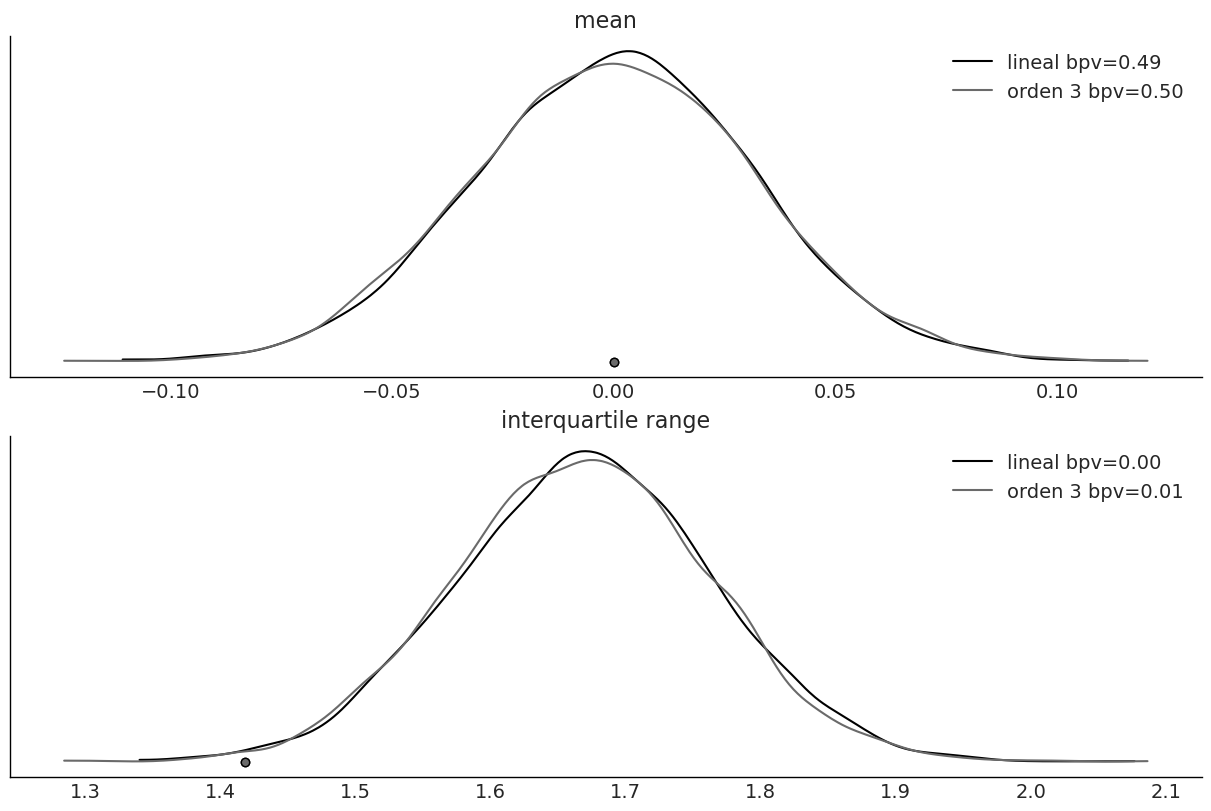

In [111]:
# means and quartile
order = 3
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharey="row")
colors = ["C0", "C1"]
titles = ["mean", "interquartile range"]
modelos = ["lineal", f"orden {order}"]
idatas = [idata_l, idata_q]


def iqr(x, a=-1):
    """interquartile range"""
    return np.subtract(*np.percentile(x, [75, 25], axis=a))


for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=axes[0], color=c)


for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=axes[1], color=c)

for (
    ax,
    title,
) in zip(axes, titles):
    ax.set_title(title)
    for idx, (c, modelo) in enumerate(zip(colors, modelos)):
        ax.legend_.legend_handles[idx]._alpha = 1
        ax.legend_.legend_handles[idx]._color = c
        ax.legend_._loc = 1
        ax.legend_.texts[idx]._text = modelo + " " + ax.legend_.texts[idx]._text

plt.savefig("../fig/lin-pol-bpv.png")


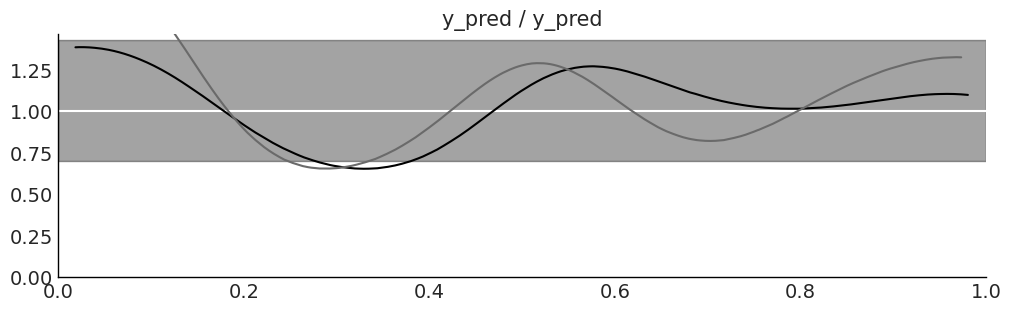

In [112]:
fig, ax = plt.subplots(figsize=(10, 3))

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, color=c, ax=ax)

plt.savefig("../fig/lin-pol-bpv2.png")

In [113]:
waic_l = az.waic(idata_l)
waic_l

Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

          Estimate       SE
elpd_waic     1.38     6.18
p_waic        2.76        -

In [114]:
waic_c = az.waic(idata_c)
waic_c

Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    51.98     7.21
p_waic        4.43        -

In [115]:
loo_l = az.loo(idata_l)
loo_l

Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

         Estimate       SE
elpd_loo     1.38     6.18
p_loo        2.76        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      112  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [142]:
loo_q = az.loo(idata_c)
loo_q

Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

         Estimate       SE
elpd_loo    51.96     7.21
p_loo        4.45        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      112  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [138]:
cmp_df = az.compare({"model_l": idata_l, "model_c": idata_c})
# cmp_df.to_markdown()
cmp_df

c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_c,0,51.959928,4.451570,0.000000,1.0,7.211155,0.000000,False,log
model_l,1,1.378147,2.759575,50.581781,0.0,6.181702,6.468731,False,log


c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


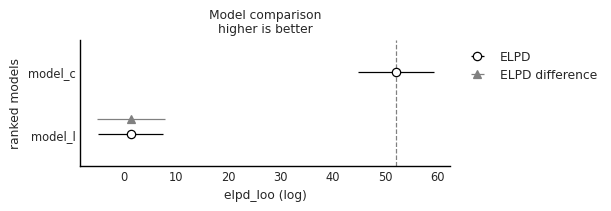

In [139]:
az.plot_compare(cmp_df)
plt.savefig("../fig/compareplot.png")

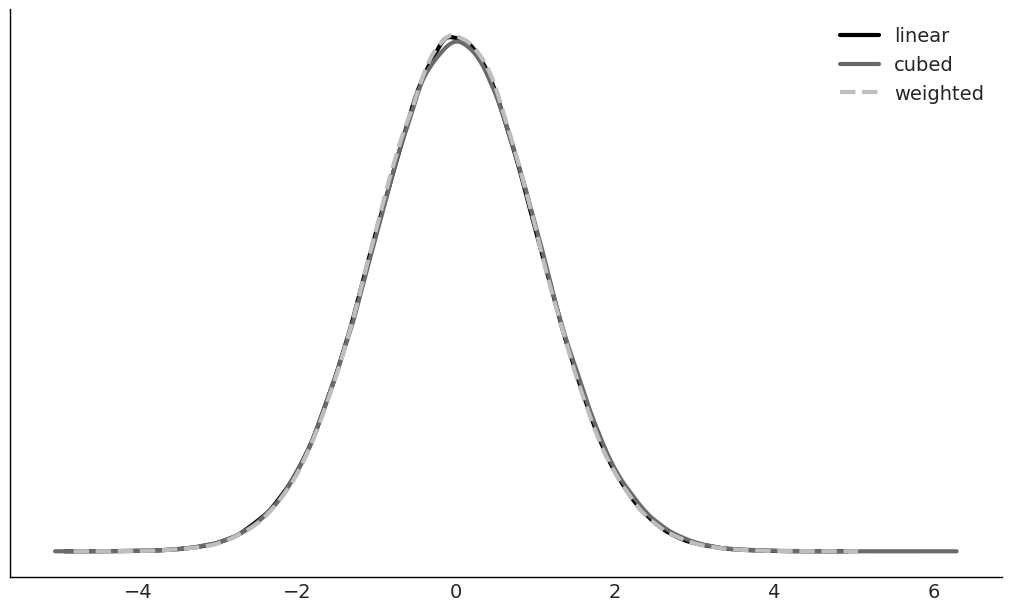

In [231]:
idata_w = az.weight_predictions(idatas, weights=[0.05, 0.95])

_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(
    idata_l.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="linear",
    ax=ax,
)
az.plot_kde(
    idata_c.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="cubed",
    ax=ax,
)
az.plot_kde(
    idata_w.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)

plt.yticks([])
plt.legend()
plt.savefig("../fig/lin-pol-weighted.png")

In [215]:
# Adding features, consumer confidence

dt1 = pd.read_csv(r"..\data\mergedDataforAnalysis.csv", index_col=[0])

gdp1 = dt1['gdp_total'].dropna()
gdp2 = np.append(119388, gdp1)
gdp3 = np.append(np.cumsum(gdp2), np.NaN)

dt1['gdp_total'] = gdp3

dt1 = dt1[['gdp_total', 'Consumentenvertrouwen_1']]
dt1.rename(columns={'Consumentenvertrouwen_1': 'Cconf'}, inplace = True)
dt1.dropna(inplace = True)
# replace 2020-Q2
dt1.loc["2020-07-01", "gdp_total"]  = 187875.7
dt1.loc["2020-07-01", "Cconf"]  = -9.33333333333333



<Axes: >

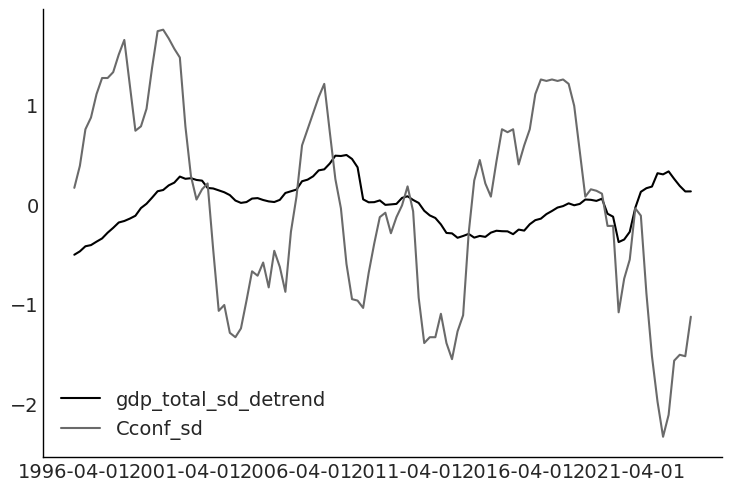

In [201]:
dt1['gdp_total_sd'] = (dt1['gdp_total'] - dt1['gdp_total'].mean())/dt1['gdp_total'].std()
dt1['gdp_total_sd_detrend'] = signal.detrend(dt1['gdp_total_sd'] )

dt1['Cconf_sd'] = (dt1['Cconf'] - dt1['Cconf'].mean())/dt1['Cconf'].std()
dt1 = dt1[['gdp_total_sd_detrend', 'Cconf_sd']]

#dt1['Cconf_sd_lag'] = dt1['Cconf_sd'].shift(1)
dt1.plot()

In [217]:
# linear model
# remove outliers
# Adding features, consumer confidence

dt1 = pd.read_csv(r"..\data\mergedDataforAnalysis.csv", index_col=[0])

# get back to normal data (not differenced)
gdp1 = dt1['gdp_total'].dropna()
gdp2 = np.append(119388, gdp1)
gdp3 = np.append(np.cumsum(gdp2), np.NaN)
dt1['gdp_total'] = gdp3

dt1 = dt1[['gdp_total', 'Consumentenvertrouwen_1']]
dt1.rename(columns={'Consumentenvertrouwen_1': 'Cconf'}, inplace = True)
dt1.dropna(inplace = True)

# replace 2020-Q2
dt1.loc["2020-07-01", "gdp_total"]  = 187875.7
dt1.loc["2020-07-01", "Cconf"]  = -9.33333333333333

dt1['gdp_total_sd'] = (dt1['gdp_total'] - dt1['gdp_total'].mean())/dt1['gdp_total'].std()
dt1['gdp_total_sd'] = signal.detrend(dt1['gdp_total_sd'] )
dt1['Cconf_sd'] = (dt1['Cconf'] - dt1['Cconf'].mean())/dt1['Cconf'].std()
dt1 = dt1[['gdp_total_sd', 'Cconf_sd']]

y = dt1['gdp_total_sd'].values
x = np.arange(0, len(y))
x_sqr = x*x
x_cube = x*x*x
y_center = (y - y.mean()) / y.std()
x_center = (x - x.mean()) / x.std()
x_sqr_center = (x_sqr - x_sqr.mean()) /x_sqr.std()
x_cube_center = (x_cube - x_cube.mean()) /x_cube.std()
constant = np.repeat(1, len(y))

N = 2000
with pm.Model() as model_l:
    # data
    x_center = pm.Data('x_center', x_center)
    y_center = pm.Data('y_center', y_center)
    
    
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)
    β2 = pm.Normal("β2", mu=0, sigma=10)
    σ = pm.HalfNormal("σ", 5)
  
    μ = pm.Deterministic("μ", α + β*x_center + β1*x_sqr_center + β2*x_sqr_center)
    
    # define likelihood
    #y_pred = pm.StudentT("y_pred", mu=μ, sigma=σ, nu = 4, observed= y_center)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed= y_center)

    idata_l = pm.sample(N, idata_kwargs={"log_likelihood": True})
    idata_l.extend(pm.sample_posterior_predictive(idata_l))

c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, β1, β2, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 271 seconds.
Sampling: [y_pred]


In [218]:

y = dt1['gdp_total_sd'].values
x = dt1['Cconf_sd'].values
y_center = (y - y.mean()) / y.std()
x_center = (x - x.mean()) / x.std()

N = 2000

with pm.Model() as model_cconf:

     # data
    x_center = pm.Data('x_center', x_center)
    y_center = pm.Data('y_center', y_center)

    α = pm.Normal("α", mu=0, sigma=1)
    β1 = pm.Normal("β1", mu=0, sigma=10, shape=1)
    σ = pm.HalfNormal("σ", 5)

    μ = pm.Deterministic("μ", α + β1*x_center)

    # define likelihood
    #y_pred = pm.StudentT("y_pred", mu=μ, sigma=σ, nu = 4, observed = y_center)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed = y_center)

    idata_cc = pm.sample(N, idata_kwargs={"log_likelihood": True})
    idata_cc.extend(pm.sample_posterior_predictive(idata_cc))

c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β1, σ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
Sampling: [y_pred]


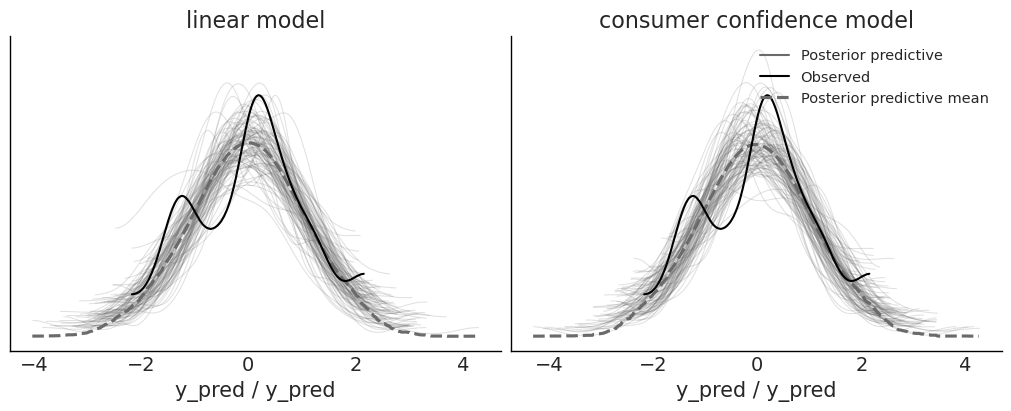

In [219]:
# compare linear with cubed (Outlier removed)
# Compare distribution with and with robust distribution (Outlier removed)

_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"])
axes[0].set_title("linear model")
az.plot_ppc(idata_cc, num_pp_samples=100, ax=axes[1], colors=["C1", "C0", "C1"])
axes[1].set_title(f"consumer confidence model")

plt.savefig("../fig/lin-pol-cconf1.png")

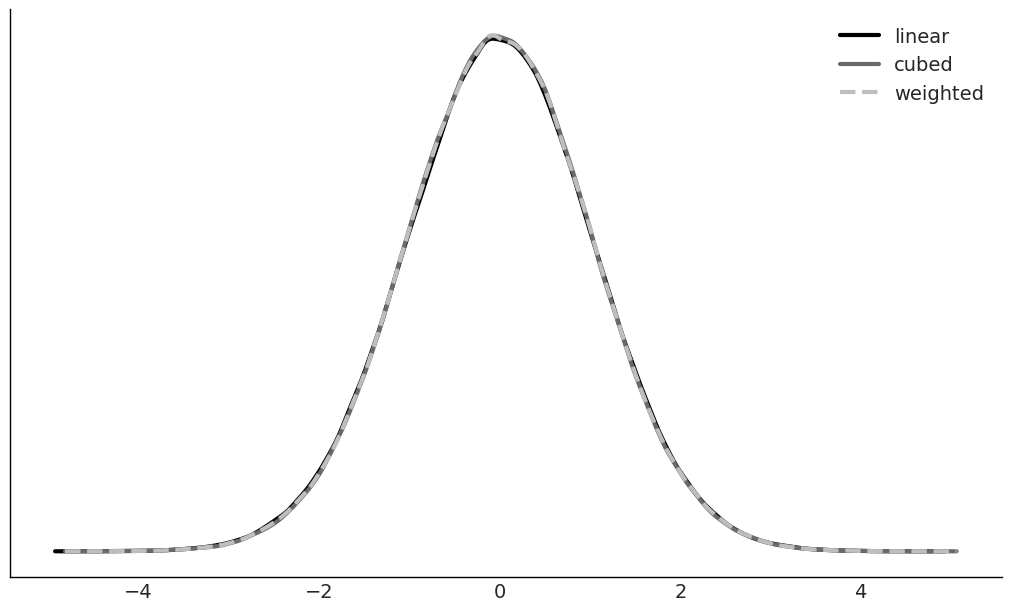

In [220]:

idatas = [idata_l, idata_cc]

idata_w = az.weight_predictions(idatas, weights=[0.5, 0.950])


_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(
    idata_l.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="linear",
    ax=ax,
)
az.plot_kde(
    idata_cc.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="cubed",
    ax=ax,
)
az.plot_kde(
    idata_w.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)

plt.yticks([])
plt.legend()
plt.savefig("../fig/lin-pol-weighted_cc.png")

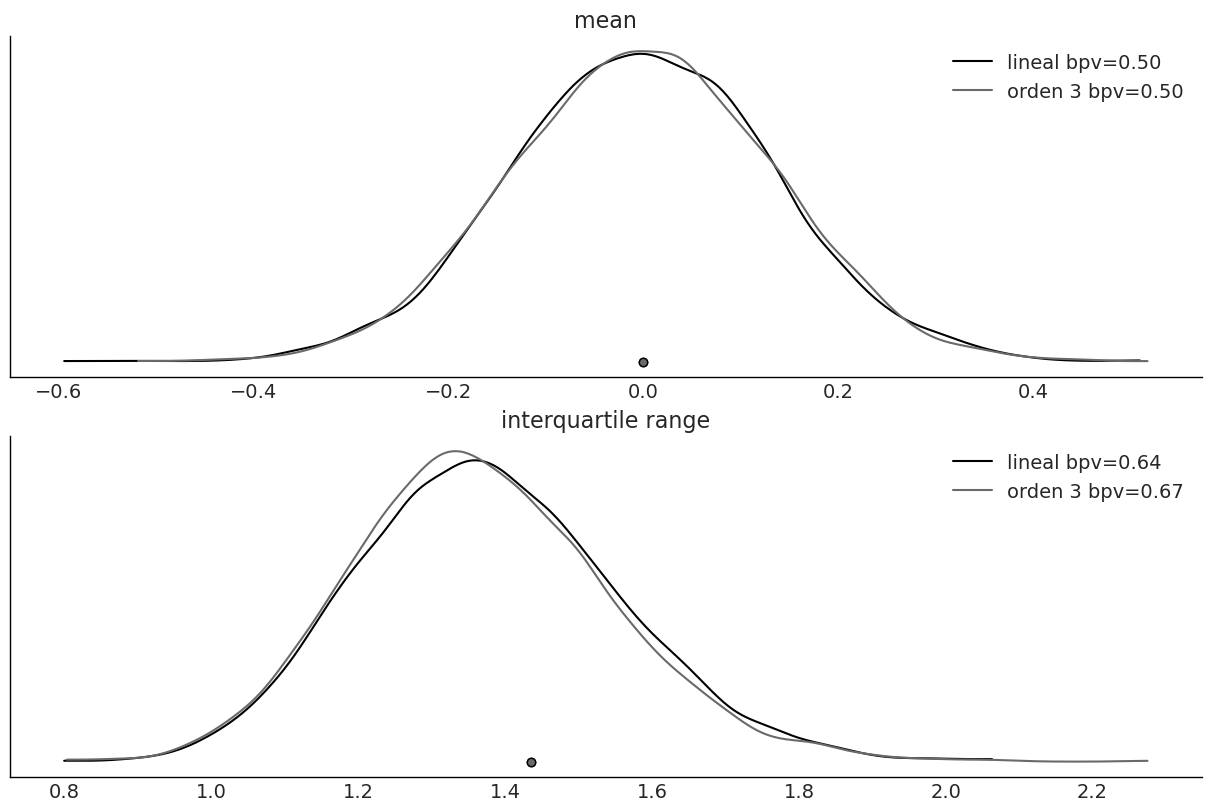

In [221]:
# means and quartile
order = 3
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharey="row")
colors = ["C0", "C1"]
titles = ["mean", "interquartile range"]
modelos = ["lineal", f"orden {order}"]
idatas = [idata_l, idata_cc]


def iqr(x, a=-1):
    """interquartile range"""
    return np.subtract(*np.percentile(x, [75, 25], axis=a))


for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=axes[0], color=c)


for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=axes[1], color=c)

for (
    ax,
    title,
) in zip(axes, titles):
    ax.set_title(title)
    for idx, (c, modelo) in enumerate(zip(colors, modelos)):
        ax.legend_.legend_handles[idx]._alpha = 1
        ax.legend_.legend_handles[idx]._color = c
        ax.legend_._loc = 1
        ax.legend_.texts[idx]._text = modelo + " " + ax.legend_.texts[idx]._text

plt.savefig("../fig/lin-pol-bpv.png")


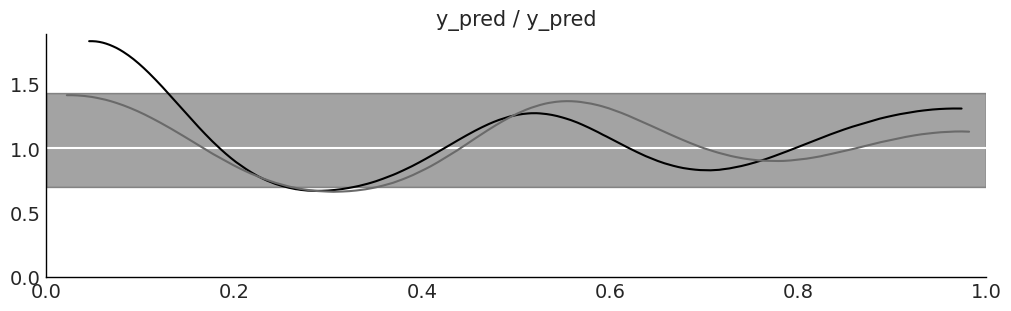

In [222]:
fig, ax = plt.subplots(figsize=(10, 3))

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, color=c, ax=ax)

plt.savefig("../fig/lin-pol-bpv2.png")

In [224]:
waic_l = az.waic(idata_l)
waic_l

Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -161.31     5.62
p_waic        3.97        -

In [225]:
waic_l = az.waic(idata_cc)
waic_l

Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -160.51     6.31
p_waic        2.59        -

In [226]:
loo_l = az.loo(idata_l)
loo_l

Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -161.33     5.62
p_loo        3.98        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      112  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [227]:
loo_l = az.loo(idata_cc)
loo_l

Computed from 8000 posterior samples and 112 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -160.51     6.31
p_loo        2.59        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      112  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [228]:
cmp_df = az.compare({"model_l": idata_l, "model_cc": idata_cc})
# cmp_df.to_markdown()
cmp_df

c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\arviz\stats\stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_cc,0,-160.510258,2.591927,0.00000,0.600967,6.312225,0.00000,False,log
model_l,1,-161.331868,3.984925,0.82161,0.399033,5.623908,2.71213,False,log


c:\Users\jpark\VSCode\pymc3_withJAX\.conda\Lib\site-packages\arviz\plots\backends\matplotlib\compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


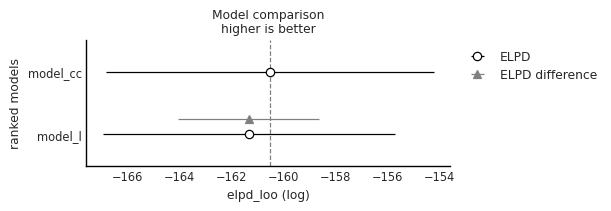

In [229]:
az.plot_compare(cmp_df)
plt.savefig("../fig/compareplot.png")

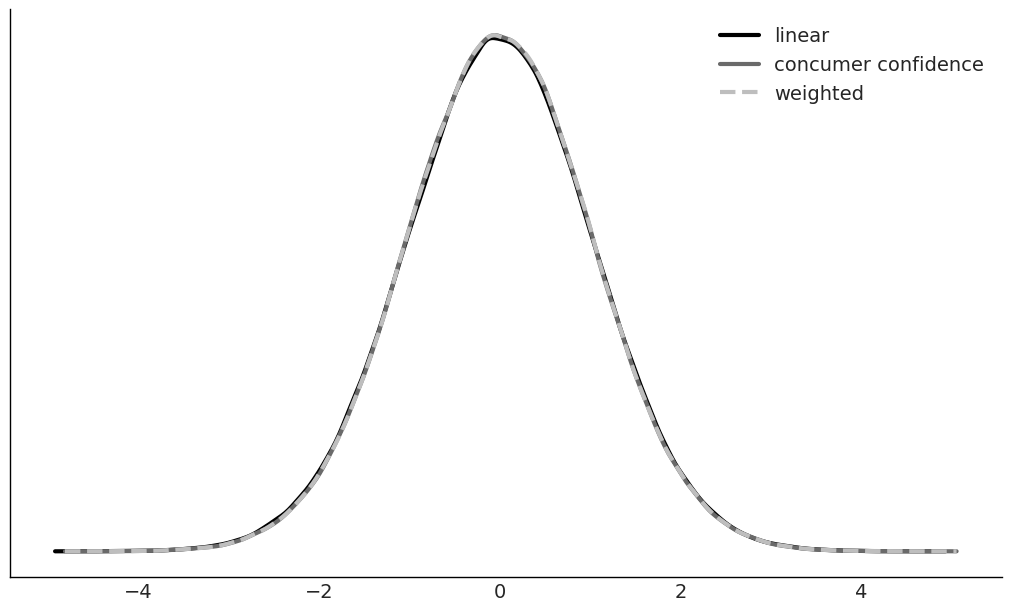

In [230]:
idata_w = az.weight_predictions(idatas, weights=[0.05, 0.95])

_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(
    idata_l.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C0", "lw": 3},
    label="linear",
    ax=ax,
)
az.plot_kde(
    idata_cc.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C1", "lw": 3},
    label="concumer confidence",
    ax=ax,
)
az.plot_kde(
    idata_w.posterior_predictive["y_pred"].values,
    plot_kwargs={"color": "C2", "lw": 3, "ls": "--"},
    label="weighted",
    ax=ax,
)

plt.yticks([])
plt.legend()
plt.savefig("../fig/lin-pol-weighted.png")

In [76]:
# remove outliers
dt1 = pd.read_csv(r"../data/gdp_eurostatMar7th.csv", index_col=[0])
dt1 = dt1[['NL']]
dt1.dropna(inplace=True)
# replace 2020-Q2
dt1[dt1.index == "2020-Q2 "] = 187875.7
y = dt1['NL'].values

x = np.arange(0, len(y))

order = 3
x_p = np.vstack([x**i for i in range(1, order + 1)])
x_c = (x_p - x_p.mean(axis=1, keepdims=True)) / x_p.std(axis=1, keepdims=True)
y_c = (y - y.mean()) / y.std()
#y_c = signal.detrend(y_c)

x_sqr = x*x
x_cube = x*x*x
y_center = (y - y.mean()) / y.std()
x_center = (x - x.mean()) / x.std()
x_sqr_center = (x_sqr - x_sqr.mean()) /x_sqr.std()
x_cube_center = (x_cube - x_cube.mean()) /x_cube.std()

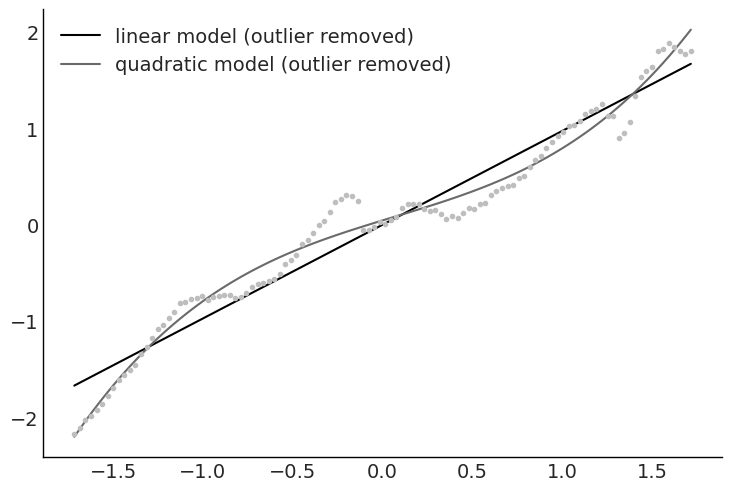

In [99]:
# how well do the models above fit the data?
posterior_l = az.extract(idata_l)
posterior_c = az.extract(idata_c)

α_l_post = posterior_l["α"].mean().item()
β_l_post = posterior_l["β"].mean().item()
y_l_post = α_l_post + β_l_post * x_center

plt.plot(x_center, y_l_post, "C0", label="linear model (outlier removed)")


α_p_post  = posterior_c["α"].mean().item()
β1_p_post = posterior_c["β1"].mean("sample").item()
β2_p_post = posterior_c["β2"].mean("sample").item()
β3_p_post = posterior_c["β3"].mean("sample").item()

y_p_post = α_p_post + β1_p_post*x_center + β2_p_post*x_sqr_center + β3_p_post*x_cube_center

plt.plot(x_center, y_p_post, "C1", label=f"quadratic model (outlier removed)")

plt.plot(x_c[0], y_c, "C2.")
plt.legend()
plt.savefig("../fig/lin-pol-fit_outlier_3.png")

In [ ]:
# import numpy as np
# x_new = np.linspace(x_center.min(), x_center.max(), 112)

# posterior_l = az.extract(idata_l)

# α_l_post = posterior_l["α"].mean().item()
# β_l_post = posterior_l["β"].mean().item()
# y_l_post = α_l_post + β_l_post * x_new

# plt.plot(dt1['x_center'], y_l_post, "C0", label="linear model")

# #################################
# posterior_p = az.extract(idata_q)

# α_p_post = posterior_p["α"].mean().item()
# β_p_post_1 = posterior_p["β1"].mean("sample")
# β_p_post_2 = posterior_p["β2"].mean("sample")
# idx = np.argsort(dt1['x_center'])

# y_p_post = α_p_post + β_p_post_1.values* dt1['x_center'] + β_p_post_2.values * dt1['x_sqr_center']

# plt.plot(dt1['x_center'], y_p_post, "C1", label=f"quadratic model")


# #################################
# posterior_c = az.extract(idata_c)

# α_p_post = posterior_c["α"].mean().item()
# β_p_post_1 = posterior_c["β1"].mean("sample")
# β_p_post_2 = posterior_c["β2"].mean("sample")
# β_p_post_3 = posterior_c["β3"].mean("sample")

# idx = np.argsort(dt1['x_center'])

# y_p_post = α_p_post + β_p_post_1.values* dt1['x_center'] + β_p_post_2.values * dt1['x_sqr_center'] + β_p_post_3.values * dt1['x_cube_center']

# plt.plot(dt1['x_center'], y_p_post, "C2", label=f"cubic model")


# ##################################
# plt.plot(dt1['x_center'], dt1['y_center'], "C2.")
# plt.legend()
# plt.savefig("../fig/lin-pol-fit.png")



In [ ]:

with pm.Model() as model_robust:

     # data
    x_center = pm.Data('x_center', x_center, mutable=False)
    x_sqr_center = pm.Data('x_sqr_center', x_sqr_center, mutable=False)
    x_cube_center = pm.Data('x_cube_center', x_cube_center, mutable=False)
    y_center = pm.Data('y_center', y_center, mutable=False)

    α = pm.Normal("α", mu=0, sigma=1)
    β1 = pm.Normal("β1", mu=0, sigma=10, shape=1)
    β2 = pm.Normal("β2", mu=0, sigma=10, shape=1)
    β3 = pm.Normal("β3", mu=0, sigma=10, shape=1)
    σ = pm.HalfNormal("σ", 5)

    μ = pm.Deterministic("μ", α + β1*x_center + β2*x_sqr_center + β3*x_cube_center)

    # define likelihood
    y_pred = pm.StudentT("y_pred", mu=μ, sigma=σ, nu = 3, observed = y_center)

    idata_robust = pm.sample(2000, idata_kwargs={"log_likelihood": True})
    idata_robust.extend(pm.sample_posterior_predictive(idata_robust))


In [ ]:
dt1.iloc[idx,:]['x_center']

In [ ]:
dt1 = pd.read_csv(r"../data/gdp_eurostatMar7th.csv")
dt1['NL'].plot()
plt.show()

In [ ]:
nl1 = dt1.loc[:, ['NL']]
nl1.dropna(inplace=True)
nl1.loc[:, 'Year'] = np.arange(0, nl1.shape[0])
nl1["NL_log"] = np.log(nl1[['NL']])

In [ ]:
nl1.loc[:, "NL_center"] = (nl1.loc[:, "NL"] - nl1.loc[:, "NL"].mean())/nl1.loc[:, "NL"].std()
nl1.loc[:, 'Year_center'] = (nl1.loc[:, "Year"] - nl1.loc[:, "Year"].mean())/nl1.loc[:, "Year"].std()

plt.scatter(nl1["Year_center"], nl1['NL_center'])
plt.xlabel("Year")
plt.ylabel("NL_center");
plt.show()

In [ ]:
with pm.Model() as model_1:
        α = pm.Normal("α", mu=0, sigma=1)
        β = pm.Normal("β", mu=0, sigma=10)
        σ = pm.HalfNormal("σ", 5)

        μ = pm.Deterministic("μ", α + β * nl1.Year_center)
        
        y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=nl1.NL_center)             

        idata_l = pm.sample(2000, idata_kwargs={"log_likelihood": True}, random_seed=4591)
        idata_l.extend(pm.sample_posterior_predictive(idata_l, random_seed=4591))



In [ ]:
y_c

In [ ]:
nl1['NL_center']

In [ ]:
az.plot_trace(idata_l, figsize=(10, 6), kind="rank_vlines");

In [ ]:
x_new = np.linspace(nl1['NL_center'].min(), nl1['NL_center'].max(), 100)

posterior_l = az.extract(idata_l)

α_l_post = posterior_l["α"].mean().item()
β_l_post = posterior_l["β"].mean().item()
y_l_post = α_l_post + β_l_post * x_new

plt.plot(x_new, y_l_post, "C0", label="linear model")

plt.plot(nl1['Year_center'], nl1['NL_center'], "C2.")

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(idata_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"])
axes[0].set_title("linear model")

plt.savefig("../fig/lin-pol-ppc.png")